##### Libraries

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [72]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
sns.set(style="whitegrid")

##### Load Dataset

In [73]:
df = pd.read_excel("Data/Online Retail.xlsx")
df.shape

(541909, 8)

##### EDA

In [74]:
# Data cleaning
print("Original shape:", df.shape)
df = df.dropna(subset=["CustomerID"])  # drop rows with missing customer IDs
df = df[df["Quantity"] > 0]           # remove negative quantities (returns)
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
print("Cleaned shape:", df.shape)

Original shape: (541909, 8)
Cleaned shape: (397924, 9)


In [75]:
import datetime as dt
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

##### Feature Engineering

In [76]:
# Compute RFM values
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                  # Frequency
    "TotalPrice": "sum"                                      # Monetary
})

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.00        326          1  77183.60
12347.00          2          7   4310.00
12348.00         75          4   1797.24
12349.00         19          1   1757.55
12350.00        310          1    334.40


##### Data Preprocessing

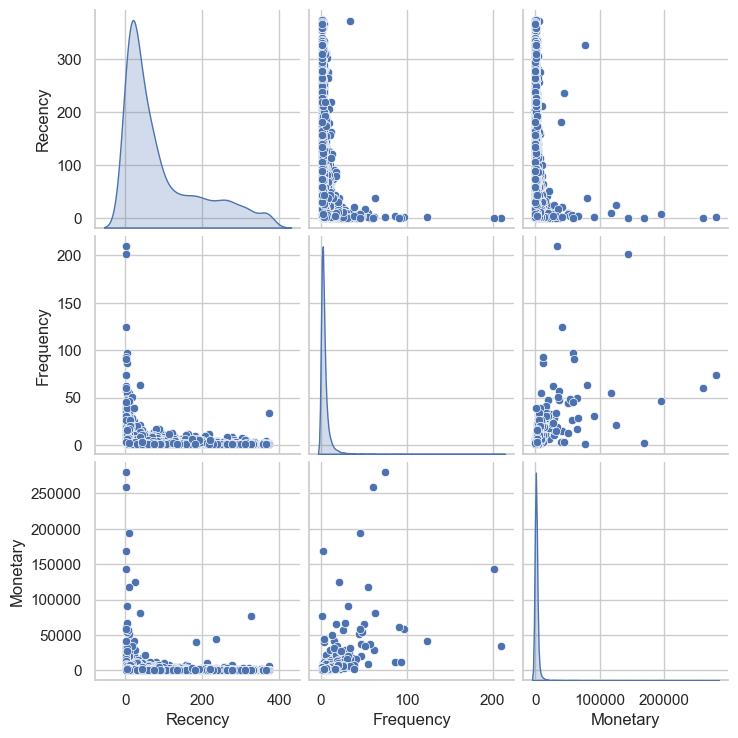

In [77]:
sns.pairplot(pd.DataFrame(rfm, columns=rfm.columns), diag_kind="kde")

In [78]:
# Log-transform Recency, Frequency, and Monetary (skewed data)
rfm["Monetary"] = np.log1p(rfm["Monetary"])
rfm["Recency"] = np.log1p(rfm["Recency"])
rfm["Frequency"] = np.sqrt(rfm["Frequency"])

# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

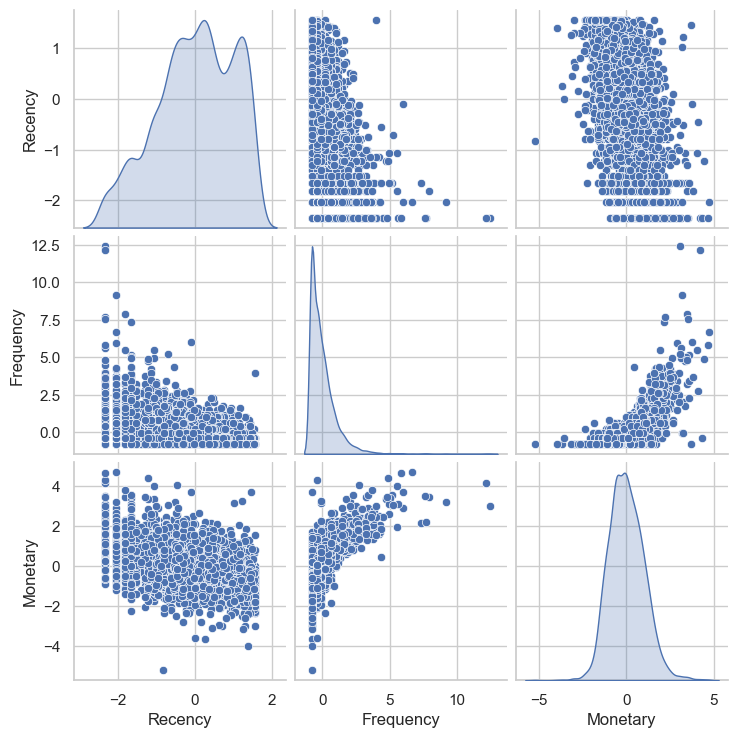

In [79]:
sns.pairplot(pd.DataFrame(rfm_scaled, columns=rfm.columns), diag_kind="kde")

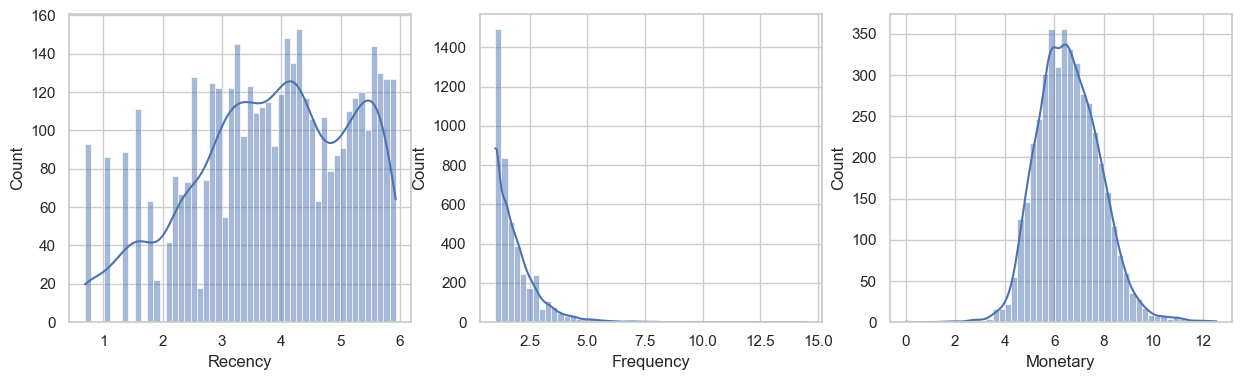

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(rfm["Recency"], bins=50, kde=True, ax=axes[0])
sns.histplot(rfm["Frequency"], bins=50, kde=True, ax=axes[1])
sns.histplot(rfm["Monetary"], bins=50, kde=True, ax=axes[2])
plt.show()

##### KMeans Clustering

In [81]:
# Find optimal number of clusters using Elbow method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

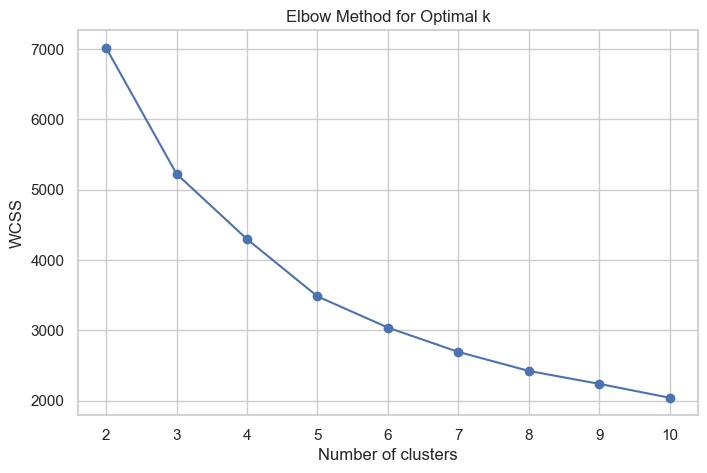

In [82]:
plt.figure(figsize=(8,5))
plt.plot(range(2,11), wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [83]:
# 7. Fit KMeans with chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


In [84]:
# 8. Evaluate with silhouette score
score = silhouette_score(rfm_scaled, rfm["Cluster"])
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.32


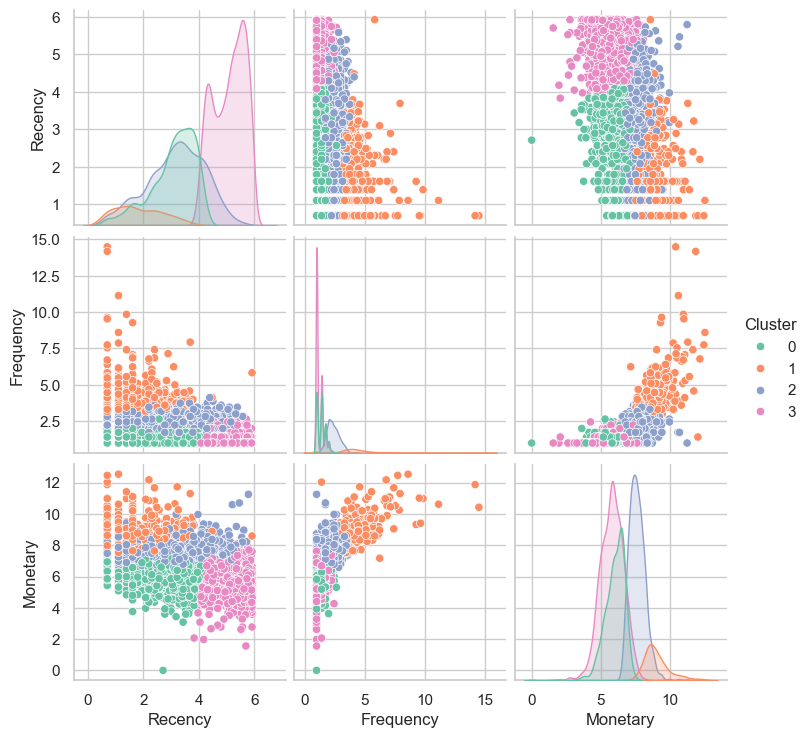

In [85]:
# 9. Visualize clusters
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="Cluster", palette="Set2")
plt.show()

In [86]:
# 10. Cluster summary
cluster_summary = rfm.groupby("Cluster").mean().round(2)
print(cluster_summary)

         Recency  Frequency  Monetary
Cluster                              
0           3.07       1.37      6.01
1           1.87       4.54      9.03
2           3.17       2.34      7.62
3           5.08       1.21      5.79


##### Principal Component Analysis

In [87]:
from sklearn.decomposition import PCA

# 1. Apply PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add PCA results back to dataframe
rfm["PCA1"] = rfm_pca[:, 0]
rfm["PCA2"] = rfm_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.7320582  0.19048537]


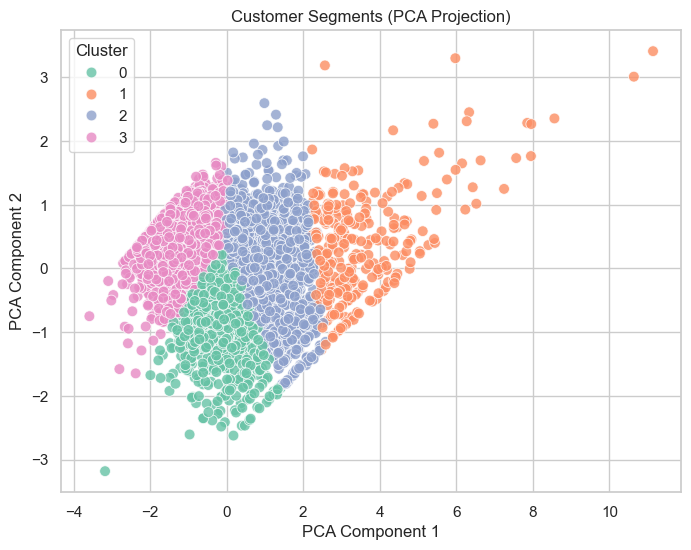

In [88]:
# 2. Plot clusters in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=rfm, palette="Set2", s=60, alpha=0.8)
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()